# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

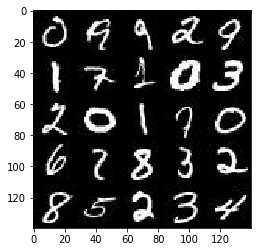

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

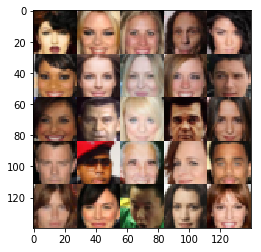

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="Input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="Input_z")
    learning_rate = tf.placeholder(tf.float32)

    return (input_real, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    drop = 0.7
    with tf.variable_scope("discriminator", reuse=reuse):
        #Input to discriminator is 28x28xChannels
        disc = tf.layers.conv2d(images, 64, 5, strides=1, padding='same',
                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        disc = tf.maximum(alpha*disc, disc)
        
        #shape=28x28x64
        disc = tf.layers.conv2d(images, 128, 5, strides=2, padding='same',
                               kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        #disc = tf.layers.batch_normalization(disc, training=True)
        disc = tf.maximum(alpha*disc, disc)
        disc = tf.nn.dropout(disc, drop)
        
        #shape=14x14x128
        disc = tf.layers.conv2d(disc, 256, 5, strides=2, padding='same',
                               kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        disc = tf.layers.batch_normalization(disc, training=True)
        disc = tf.maximum(alpha*disc, disc)
        disc = tf.nn.dropout(disc, drop)
        
        #Flattening
        flat = tf.contrib.layers.flatten(disc)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [15]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    drop = 0.5
    reuse = True if is_train==False else False
    with tf.variable_scope("generator", reuse=reuse):
        gen = tf.layers.dense(z, 7*7*256)
        gen = tf.reshape(gen, (-1,7,7,256))
        
        gen = tf.layers.batch_normalization(gen, training=is_train)
        gen = tf.maximum(alpha*gen, gen)
        gen = tf.nn.dropout(gen, drop)

        gen = tf.layers.conv2d_transpose(gen, 128, 5, strides=2, padding='same', 
                                         kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        gen = tf.maximum(alpha*gen, gen)
        gen = tf.nn.dropout(gen, drop)
        
        gen = tf.layers.conv2d_transpose(gen, 64, 5, strides=2, padding='same',
                                         kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        gen = tf.maximum(alpha*gen, gen)
        gen = tf.nn.dropout(gen, drop)
        
        gen = tf.layers.conv2d_transpose(gen, 32, 5, strides=1, padding='same',
                                         kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        gen = tf.maximum(alpha*gen, gen)
        gen = tf.nn.dropout(gen, drop)
        
        logits = tf.layers.conv2d_transpose(gen, out_channel_dim, 5, strides=1, padding='same',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        out = tf.tanh(logits)
        return out
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen_model = generator(input_z, out_channel_dim)
    disc_model_real, disc_logits_real = discriminator(input_real)
    disc_model_fake, disc_logits_fake = discriminator(gen_model, reuse=True)
    
    disc_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_real, labels=tf.ones_like(disc_model_real)*0.9))
    disc_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake, labels=tf.zeros_like(disc_model_fake)))
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake, labels=tf.ones_like(disc_model_fake)))
    
    disc_total_loss = disc_loss_real + disc_loss_fake
    
    return (disc_total_loss, gen_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    train_vars = tf.trainable_variables()
    disc_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        gen_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
        disc_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=disc_vars)
    return (disc_train_opt, gen_train_opt)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    channels = 3 if data_image_mode == 'RGB' else 1
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    step = 0    
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                #For printing and sampling purposes
                step+=1
                #Random noise for z
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                #Optimizers
                #Discriminator
                _, train_loss_d = sess.run([d_opt,d_loss], feed_dict={input_real : batch_images,
                                               input_z : batch_z,
                                               lr : learning_rate})
                #Generator
                _, train_loss_g = sess.run([g_opt,g_loss], feed_dict={input_z : batch_z,
                                               input_real : batch_images,
                                               lr : learning_rate})
                _ = sess.run([g_opt], feed_dict={input_z : batch_z,
                                               input_real : batch_images,
                                               lr : learning_rate})
                '''_ = sess.run([g_opt], feed_dict={input_z : batch_z,
                                               input_real : batch_images,
                                               lr : learning_rate})'''
                if(step%25 == 0):
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if(step%100 == 0):
                    show_generator_output(sess, 10, input_z, channels, data_image_mode)                                                                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.3980... Generator Loss: 1.6791
Epoch 1/2... Discriminator Loss: 1.2323... Generator Loss: 2.3791
Epoch 1/2... Discriminator Loss: 0.9439... Generator Loss: 2.2387
Epoch 1/2... Discriminator Loss: 1.3819... Generator Loss: 1.8214


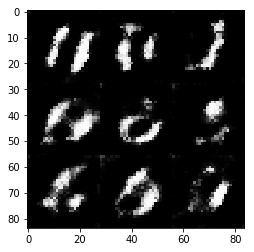

Epoch 1/2... Discriminator Loss: 1.1481... Generator Loss: 1.2835
Epoch 1/2... Discriminator Loss: 1.1118... Generator Loss: 0.9762
Epoch 1/2... Discriminator Loss: 1.2080... Generator Loss: 1.9607
Epoch 1/2... Discriminator Loss: 1.3108... Generator Loss: 1.8418


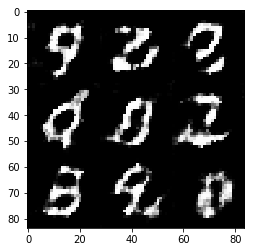

Epoch 1/2... Discriminator Loss: 1.3346... Generator Loss: 1.4321
Epoch 1/2... Discriminator Loss: 1.0074... Generator Loss: 1.3098
Epoch 1/2... Discriminator Loss: 1.1324... Generator Loss: 1.3364
Epoch 1/2... Discriminator Loss: 1.2765... Generator Loss: 1.3137


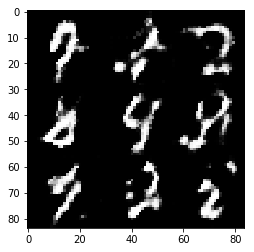

Epoch 1/2... Discriminator Loss: 1.2180... Generator Loss: 1.3704
Epoch 1/2... Discriminator Loss: 1.2028... Generator Loss: 1.3367
Epoch 1/2... Discriminator Loss: 1.0237... Generator Loss: 1.3280
Epoch 1/2... Discriminator Loss: 1.0866... Generator Loss: 1.2181


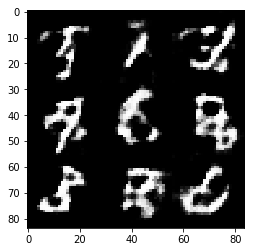

Epoch 1/2... Discriminator Loss: 1.0555... Generator Loss: 1.9958
Epoch 1/2... Discriminator Loss: 1.2019... Generator Loss: 1.2043
Epoch 1/2... Discriminator Loss: 1.0993... Generator Loss: 1.4424
Epoch 1/2... Discriminator Loss: 1.1913... Generator Loss: 1.2389


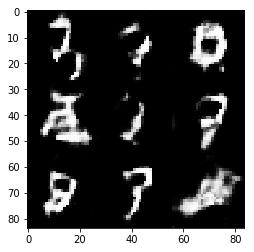

Epoch 1/2... Discriminator Loss: 0.9586... Generator Loss: 1.1653
Epoch 1/2... Discriminator Loss: 1.0079... Generator Loss: 1.8563
Epoch 1/2... Discriminator Loss: 1.2945... Generator Loss: 1.0710
Epoch 1/2... Discriminator Loss: 1.2100... Generator Loss: 1.3308


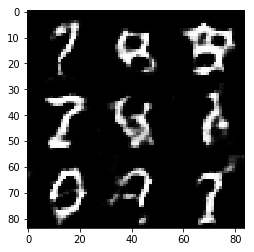

Epoch 1/2... Discriminator Loss: 1.2689... Generator Loss: 0.8500
Epoch 1/2... Discriminator Loss: 1.1537... Generator Loss: 1.4446
Epoch 1/2... Discriminator Loss: 1.2817... Generator Loss: 1.7694
Epoch 1/2... Discriminator Loss: 1.1373... Generator Loss: 1.5590


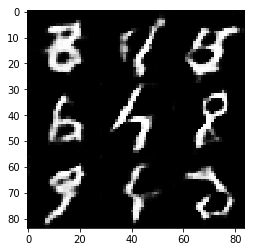

Epoch 1/2... Discriminator Loss: 1.0527... Generator Loss: 1.1929
Epoch 1/2... Discriminator Loss: 1.3690... Generator Loss: 1.5409
Epoch 1/2... Discriminator Loss: 1.1314... Generator Loss: 1.5583
Epoch 1/2... Discriminator Loss: 1.2677... Generator Loss: 2.0596


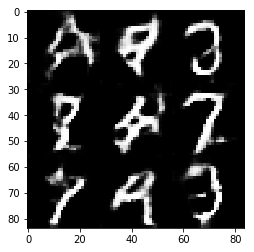

Epoch 1/2... Discriminator Loss: 1.1422... Generator Loss: 1.2290
Epoch 1/2... Discriminator Loss: 1.1089... Generator Loss: 1.2632
Epoch 1/2... Discriminator Loss: 1.2094... Generator Loss: 1.1187
Epoch 1/2... Discriminator Loss: 1.2660... Generator Loss: 0.9917


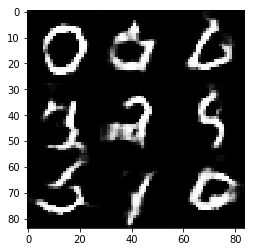

Epoch 1/2... Discriminator Loss: 1.1463... Generator Loss: 1.5525
Epoch 1/2... Discriminator Loss: 1.1310... Generator Loss: 1.1760
Epoch 1/2... Discriminator Loss: 1.0663... Generator Loss: 1.4911
Epoch 1/2... Discriminator Loss: 1.3075... Generator Loss: 0.9288


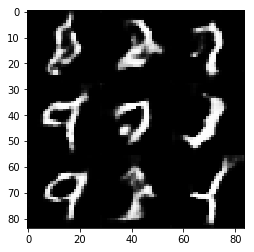

Epoch 1/2... Discriminator Loss: 1.0122... Generator Loss: 1.1794
Epoch 1/2... Discriminator Loss: 1.0447... Generator Loss: 1.5682
Epoch 1/2... Discriminator Loss: 1.1267... Generator Loss: 1.3563
Epoch 1/2... Discriminator Loss: 1.2982... Generator Loss: 1.1480


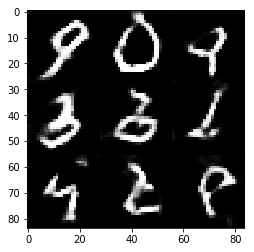

Epoch 1/2... Discriminator Loss: 1.1287... Generator Loss: 1.0279
Epoch 1/2... Discriminator Loss: 1.0024... Generator Loss: 1.7317
Epoch 1/2... Discriminator Loss: 1.3564... Generator Loss: 0.9794
Epoch 1/2... Discriminator Loss: 1.0419... Generator Loss: 1.6558


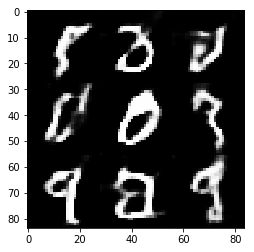

Epoch 1/2... Discriminator Loss: 1.1417... Generator Loss: 1.4277
Epoch 1/2... Discriminator Loss: 1.2279... Generator Loss: 1.8212
Epoch 1/2... Discriminator Loss: 1.2347... Generator Loss: 1.1394
Epoch 1/2... Discriminator Loss: 0.9422... Generator Loss: 1.4037


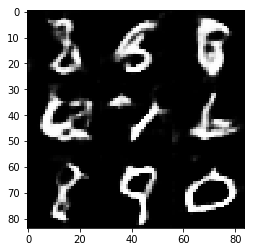

Epoch 1/2... Discriminator Loss: 1.1144... Generator Loss: 1.0424
Epoch 1/2... Discriminator Loss: 1.2482... Generator Loss: 1.9883
Epoch 1/2... Discriminator Loss: 1.1900... Generator Loss: 1.1554
Epoch 1/2... Discriminator Loss: 1.2116... Generator Loss: 1.4915


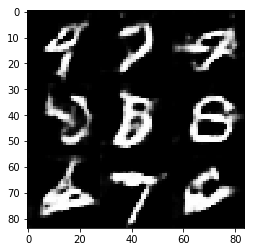

Epoch 1/2... Discriminator Loss: 1.1676... Generator Loss: 1.1556
Epoch 1/2... Discriminator Loss: 1.2104... Generator Loss: 1.6829
Epoch 1/2... Discriminator Loss: 1.2777... Generator Loss: 1.6685
Epoch 1/2... Discriminator Loss: 1.1383... Generator Loss: 1.2958


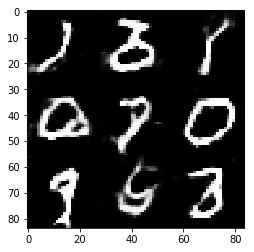

Epoch 1/2... Discriminator Loss: 1.0035... Generator Loss: 1.6207
Epoch 1/2... Discriminator Loss: 1.2693... Generator Loss: 1.2734
Epoch 1/2... Discriminator Loss: 1.2919... Generator Loss: 1.2222
Epoch 1/2... Discriminator Loss: 1.1526... Generator Loss: 1.4837


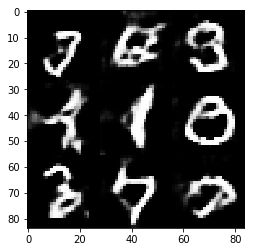

Epoch 1/2... Discriminator Loss: 1.0190... Generator Loss: 1.6251
Epoch 1/2... Discriminator Loss: 1.0675... Generator Loss: 1.6602
Epoch 1/2... Discriminator Loss: 1.3597... Generator Loss: 1.2037
Epoch 1/2... Discriminator Loss: 1.0435... Generator Loss: 1.8261


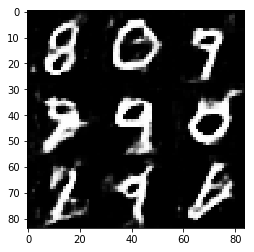

Epoch 1/2... Discriminator Loss: 1.0682... Generator Loss: 1.5986
Epoch 1/2... Discriminator Loss: 0.9483... Generator Loss: 1.4241
Epoch 1/2... Discriminator Loss: 1.1787... Generator Loss: 1.7780
Epoch 1/2... Discriminator Loss: 1.0120... Generator Loss: 1.0528


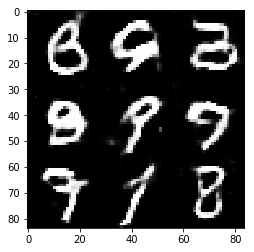

Epoch 1/2... Discriminator Loss: 1.3512... Generator Loss: 0.9351
Epoch 1/2... Discriminator Loss: 1.3193... Generator Loss: 1.0455
Epoch 1/2... Discriminator Loss: 0.9508... Generator Loss: 1.8570
Epoch 2/2... Discriminator Loss: 1.1078... Generator Loss: 1.4742


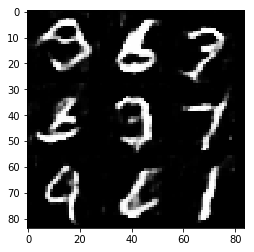

Epoch 2/2... Discriminator Loss: 0.9670... Generator Loss: 1.3669
Epoch 2/2... Discriminator Loss: 1.2102... Generator Loss: 1.5755
Epoch 2/2... Discriminator Loss: 1.4168... Generator Loss: 1.6926
Epoch 2/2... Discriminator Loss: 0.9538... Generator Loss: 2.0193


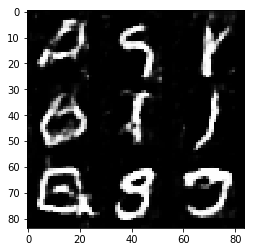

Epoch 2/2... Discriminator Loss: 1.1640... Generator Loss: 0.6813
Epoch 2/2... Discriminator Loss: 1.0803... Generator Loss: 1.4219
Epoch 2/2... Discriminator Loss: 1.3462... Generator Loss: 1.9279
Epoch 2/2... Discriminator Loss: 1.0933... Generator Loss: 1.2733


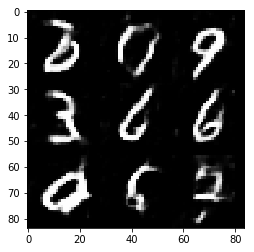

Epoch 2/2... Discriminator Loss: 1.3768... Generator Loss: 1.7463
Epoch 2/2... Discriminator Loss: 1.0611... Generator Loss: 1.6640
Epoch 2/2... Discriminator Loss: 1.3004... Generator Loss: 1.0540
Epoch 2/2... Discriminator Loss: 1.1441... Generator Loss: 0.7908


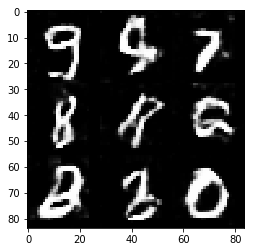

Epoch 2/2... Discriminator Loss: 1.0407... Generator Loss: 1.4565
Epoch 2/2... Discriminator Loss: 1.0421... Generator Loss: 1.5487
Epoch 2/2... Discriminator Loss: 1.0145... Generator Loss: 1.3108
Epoch 2/2... Discriminator Loss: 1.1892... Generator Loss: 1.6105


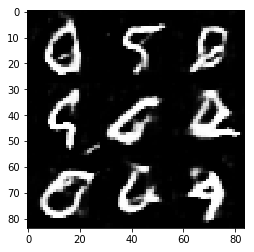

Epoch 2/2... Discriminator Loss: 1.2568... Generator Loss: 0.9328
Epoch 2/2... Discriminator Loss: 1.1594... Generator Loss: 1.4281
Epoch 2/2... Discriminator Loss: 1.1742... Generator Loss: 1.3608
Epoch 2/2... Discriminator Loss: 1.1486... Generator Loss: 1.2964


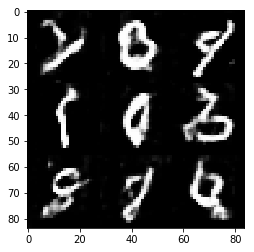

Epoch 2/2... Discriminator Loss: 0.9641... Generator Loss: 1.5506
Epoch 2/2... Discriminator Loss: 1.0779... Generator Loss: 1.5632
Epoch 2/2... Discriminator Loss: 1.2839... Generator Loss: 1.2140
Epoch 2/2... Discriminator Loss: 1.1597... Generator Loss: 1.3421


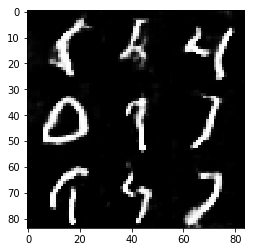

Epoch 2/2... Discriminator Loss: 1.0351... Generator Loss: 1.6904
Epoch 2/2... Discriminator Loss: 0.9474... Generator Loss: 1.0808
Epoch 2/2... Discriminator Loss: 1.1007... Generator Loss: 1.3374
Epoch 2/2... Discriminator Loss: 1.2886... Generator Loss: 0.8778


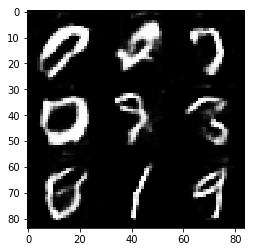

Epoch 2/2... Discriminator Loss: 1.1965... Generator Loss: 1.1826
Epoch 2/2... Discriminator Loss: 1.1849... Generator Loss: 0.8307
Epoch 2/2... Discriminator Loss: 1.1302... Generator Loss: 1.3515
Epoch 2/2... Discriminator Loss: 1.1046... Generator Loss: 1.1975


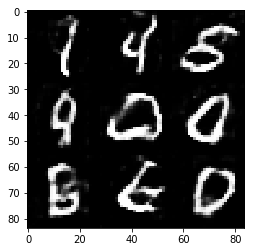

Epoch 2/2... Discriminator Loss: 1.1658... Generator Loss: 1.3355
Epoch 2/2... Discriminator Loss: 1.1971... Generator Loss: 1.2803
Epoch 2/2... Discriminator Loss: 1.1145... Generator Loss: 1.2276
Epoch 2/2... Discriminator Loss: 0.9405... Generator Loss: 1.8482


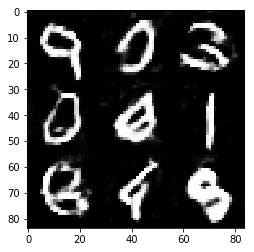

Epoch 2/2... Discriminator Loss: 1.1023... Generator Loss: 1.9012
Epoch 2/2... Discriminator Loss: 0.9996... Generator Loss: 1.1749
Epoch 2/2... Discriminator Loss: 1.2246... Generator Loss: 1.3415
Epoch 2/2... Discriminator Loss: 1.1880... Generator Loss: 1.8583


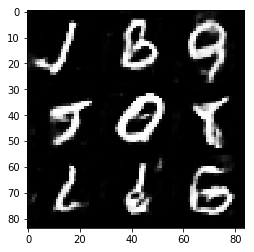

Epoch 2/2... Discriminator Loss: 1.0258... Generator Loss: 1.3412
Epoch 2/2... Discriminator Loss: 1.1132... Generator Loss: 1.1918
Epoch 2/2... Discriminator Loss: 1.3912... Generator Loss: 1.8180
Epoch 2/2... Discriminator Loss: 1.1628... Generator Loss: 0.9121


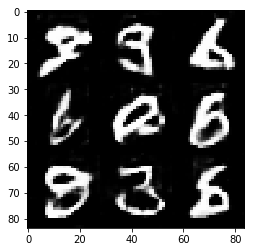

Epoch 2/2... Discriminator Loss: 1.0376... Generator Loss: 1.4759
Epoch 2/2... Discriminator Loss: 1.2276... Generator Loss: 1.9745
Epoch 2/2... Discriminator Loss: 1.0718... Generator Loss: 1.3422
Epoch 2/2... Discriminator Loss: 1.2930... Generator Loss: 0.9311


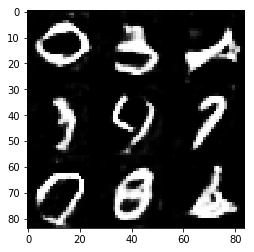

Epoch 2/2... Discriminator Loss: 1.1283... Generator Loss: 1.2939
Epoch 2/2... Discriminator Loss: 1.1973... Generator Loss: 1.0517
Epoch 2/2... Discriminator Loss: 1.2078... Generator Loss: 1.7401
Epoch 2/2... Discriminator Loss: 1.0655... Generator Loss: 1.1875


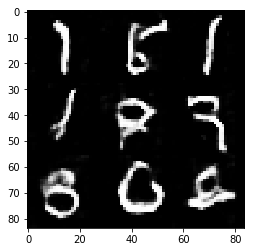

Epoch 2/2... Discriminator Loss: 1.1535... Generator Loss: 0.8892
Epoch 2/2... Discriminator Loss: 1.1950... Generator Loss: 1.2202
Epoch 2/2... Discriminator Loss: 1.0610... Generator Loss: 1.5352
Epoch 2/2... Discriminator Loss: 1.3128... Generator Loss: 1.1564


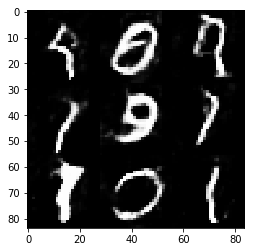

Epoch 2/2... Discriminator Loss: 1.0988... Generator Loss: 1.2879
Epoch 2/2... Discriminator Loss: 1.3273... Generator Loss: 1.8035
Epoch 2/2... Discriminator Loss: 1.1241... Generator Loss: 1.3307
Epoch 2/2... Discriminator Loss: 1.1999... Generator Loss: 1.5123


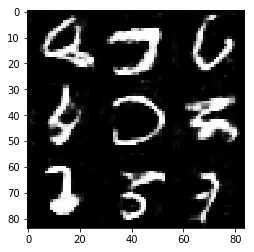

Epoch 2/2... Discriminator Loss: 1.0772... Generator Loss: 1.0163
Epoch 2/2... Discriminator Loss: 1.1122... Generator Loss: 1.5226
Epoch 2/2... Discriminator Loss: 1.1319... Generator Loss: 1.5858
Epoch 2/2... Discriminator Loss: 1.1244... Generator Loss: 1.8787


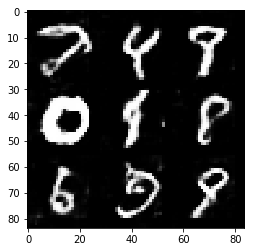

Epoch 2/2... Discriminator Loss: 1.3613... Generator Loss: 1.9331
Epoch 2/2... Discriminator Loss: 0.9790... Generator Loss: 1.0879
Epoch 2/2... Discriminator Loss: 1.0635... Generator Loss: 1.7213
Epoch 2/2... Discriminator Loss: 1.0662... Generator Loss: 1.3457


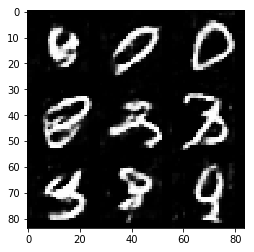

Epoch 2/2... Discriminator Loss: 1.0113... Generator Loss: 1.6928
Epoch 2/2... Discriminator Loss: 1.1366... Generator Loss: 0.9818
Epoch 2/2... Discriminator Loss: 1.1515... Generator Loss: 0.7507
Epoch 2/2... Discriminator Loss: 1.1991... Generator Loss: 1.2869


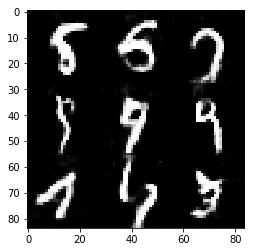

Epoch 2/2... Discriminator Loss: 1.1740... Generator Loss: 1.2898
Epoch 2/2... Discriminator Loss: 1.2901... Generator Loss: 1.9668


In [15]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 0.8708... Generator Loss: 5.0988
Epoch 1/2... Discriminator Loss: 1.2973... Generator Loss: 3.4486
Epoch 1/2... Discriminator Loss: 1.0214... Generator Loss: 2.6807
Epoch 1/2... Discriminator Loss: 1.2110... Generator Loss: 2.4450


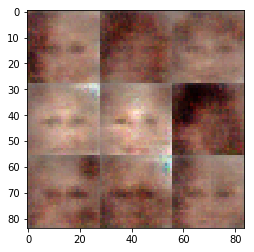

Epoch 1/2... Discriminator Loss: 0.9099... Generator Loss: 2.3761
Epoch 1/2... Discriminator Loss: 0.7780... Generator Loss: 2.6031
Epoch 1/2... Discriminator Loss: 1.0811... Generator Loss: 2.4042
Epoch 1/2... Discriminator Loss: 1.6198... Generator Loss: 3.5561


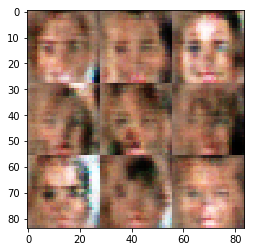

Epoch 1/2... Discriminator Loss: 1.3819... Generator Loss: 2.3239
Epoch 1/2... Discriminator Loss: 1.2761... Generator Loss: 1.8381


In [ ]:
batch_size = 60
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.